In [1]:
import csv
import subprocess
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
class Experiment:
    def __init__(self, functions_file, optimization_file):
        self.functions_file = functions_file
        self.optimization_file = optimization_file
        self.functions_param=[]
        self.optimization_param=[]
        
        
        self.f_param_list_function_id=[]
        self.f_param_list_name=[]
        self.f_param_list_range_low=[]
        self.f_param_list_range_high=[]
        self.f_param_list_dimensions_vector=[]
            
        self.opt_param_list_id = []
        self.opt_param_list_name = []
        self.opt_param_list_config_file = []
            
        self.readFunctionsFile()
        self.readOptimizationFile()
        self.solution_file = 'solutions.csv'
        self.solution_df = None
        
    def readFunctionsFile(self):
        with open(self.functions_file) as csvfile:
            read_csv = csv.reader(csvfile, delimiter=',')
            for row in read_csv:
                self.functions_param.append(row)
        
        #decode the functions_param
        for i in range(1,len(self.functions_param)):
            self.f_param_list_function_id.append(self.functions_param[i][0]) #function_id
            self.f_param_list_name.append(self.functions_param[i][1]) # function name
            self.f_param_list_range_low.append(self.functions_param[i][2]) # range low
            self.f_param_list_range_high.append(self.functions_param[i][3]) # range high
            self.f_param_list_dimensions_vector.append(self.functions_param[i][4:]) # dimension vector, from 4 to the last element
            
    def readOptimizationFile(self):
        with open(self.optimization_file) as csvfile:
            read_csv = csv.reader(csvfile, delimiter=',')
            for row in read_csv:
                self.optimization_param.append(row)
        
        #decode the functions_param
        for i in range(1,len(self.optimization_param)):
            self.opt_param_list_id.append(self.optimization_param[i][0]) #opt algorithm id
            self.opt_param_list_name.append(self.optimization_param[i][1]) #algo name
            self.opt_param_list_config_file.append(self.optimization_param[i][2]) # config file
            
    def delete_all_output_files(self):
        files = glob.glob('a*.csv')
        for f in files:
            os.remove(f)
            
    def merge_all_output_files(self):
        files = glob.glob("./a*.csv")
        #print(files)
        solutions=[]
        for f in files:
            with open(f) as csvfile:
                read_csv = csv.reader(csvfile, delimiter=',')
                for i,row in enumerate(read_csv):
                    if i != 0: # first row
                        solutions.append(row)
        #print(solutions)
        
        
        with open(self.solution_file, mode='w') as solution_file:
            writer = csv.writer(solution_file, delimiter=',', lineterminator='\n',quotechar='"', quoting=csv.QUOTE_MINIMAL)
            writer.writerow(['algorithm_id'
                             ,'function_id'
                             ,'n_runs'
                             ,'dimensions'
                             ,'range_low'
                             ,'range_high'
                             ,'mean'
                             ,'std_dev'
                             ,'range'
                             ,'median'
                             ,'time_ms'
                             ,'range_min'
                             ,'range_max'
                            ])
            writer.writerows(solutions)
            
    def plot(self):
        df=pd.read_csv('solutions.csv',index_col=False)
        df.sort_values(by=['algorithm_id', 'function_id'], inplace = True)
        self.solution_df = df
        
        #-----------plot running time
        fig, ax = plt.subplots(figsize=(8,6))
        for label, data in df.groupby('algorithm_id'):
            data.plot(kind='line',x='function_id',y='time_ms',ax=ax, style='o--', xticks=data['function_id'], label='algorithm_id: %d'%label)
        plt.ylabel('time [ms]')    
        plt.legend()
        plt.grid()
        plt.title('Running time')
        
   
        #---------plot statistics
        for id, data in df.groupby('function_id'):
            fig, ax = plt.subplots(figsize=(8,4))
            plt.errorbar(data['algorithm_id'],data['mean'],yerr=data['std_dev'],fmt='o:', markersize=3, capsize=5, label='mean and std_dev')
            plt.plot(data['algorithm_id'],data['median'],label='median')
            plt.fill_between(data['algorithm_id'], data['range_min'], data['range_max'], color='gray', alpha=0.2, label='range')
            plt.xticks(data['algorithm_id'])
            plt.title("f%d : %s"%(id, self.f_param_list_name[id-1]))
            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            plt.xlabel('algorithm_id')
            plt.ylabel('solution')
            plt.grid()
        

    def run(self, n_runs):
        
        #delete all temp files
        self.delete_all_output_files()
        
        for k in range(len(self.opt_param_list_id)): # run each optimization algorithm
            process_list = []
            for i in range(len(self.f_param_list_function_id)): # run each function  
                for dimension in self.f_param_list_dimensions_vector[i]: # run different dimensions of each function
                    #subprocess.Popen() can be multi process, subprocess.run() need to wait one process to finish
                    process = subprocess.Popen([
                                    #"../bin/debug/project.exe"
                                    "../bin/debug/project.o"
                                    ,self.opt_param_list_id[k] # optimization algorithm id
                                    ,self.opt_param_list_config_file[k]  # optimization configuration file
                                    ,str(n_runs) # number of runs            
                                    ,self.f_param_list_function_id[i] #function_id 
                                    ,str(dimension)
                                    ,self.f_param_list_range_low[i]
                                    ,self.f_param_list_range_high[i]
                                   ])
                    process_list.append(process)

            # wait every process to finish
            for p in process_list:
                p.wait()
            print("----finished----alg: %d"%k)
        
        self.merge_all_output_files()
        #delete all temp files
        self.delete_all_output_files()

In [3]:
test = Experiment('../config/function_list.csv', '../config/optimization_alg_list.csv') 

In [4]:
test.opt_param_list_name

['GA',
 'DE_best_1_exp',
 'DE_rand_1_exp',
 'DE_randbest_1_exp',
 'DE_best_2_exp',
 'DE_rand_2_exp',
 'DE_best_1_bin',
 'DE_rand_1_bin',
 'DE_randbest_1_bin',
 'DE_best_2_bin',
 'DE_rand_2_bin']

In [8]:
test.run(50) # n runs

----finished----alg: 0
----finished----alg: 1
----finished----alg: 2
----finished----alg: 3
----finished----alg: 4
----finished----alg: 5
----finished----alg: 6
----finished----alg: 7
----finished----alg: 8
----finished----alg: 9
----finished----alg: 10


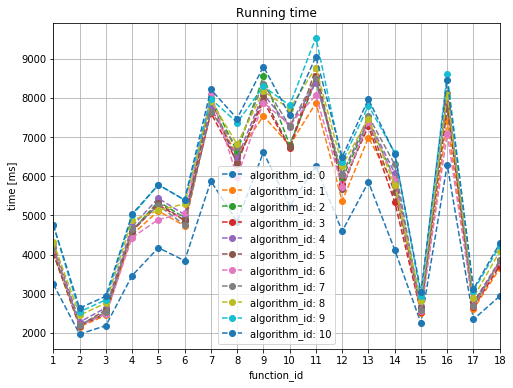

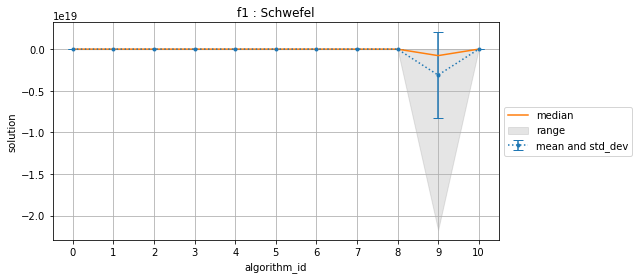

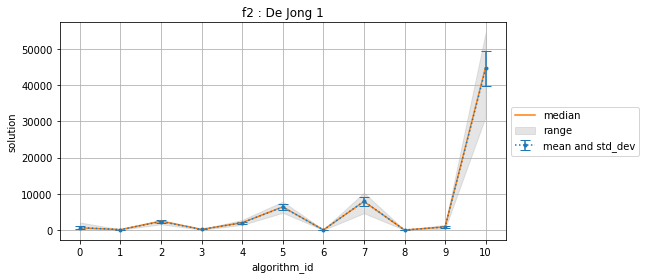

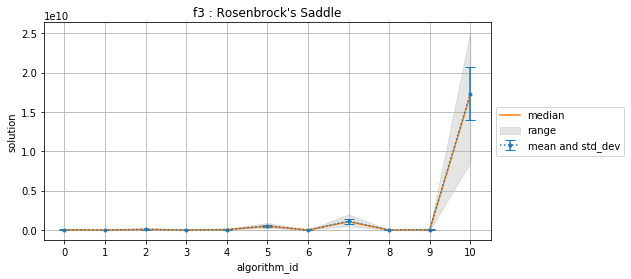

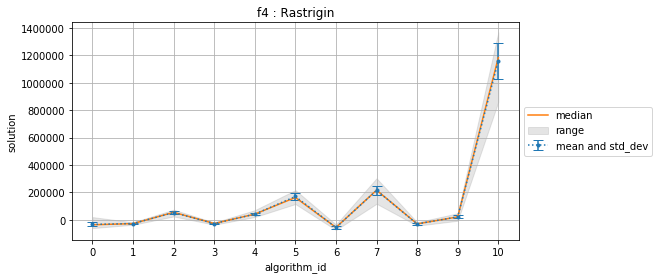

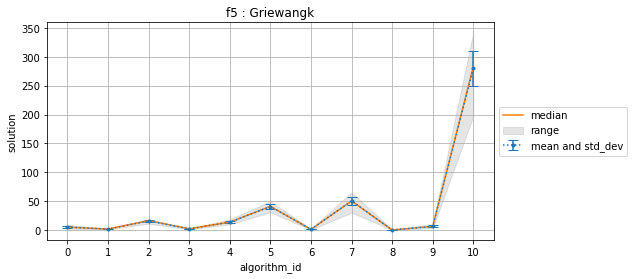

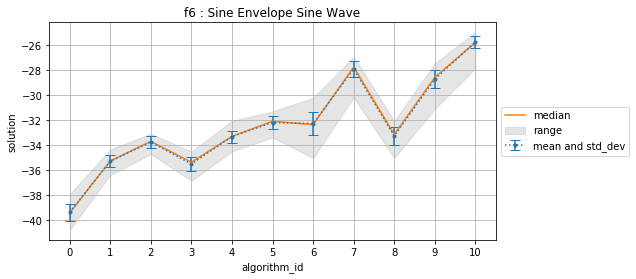

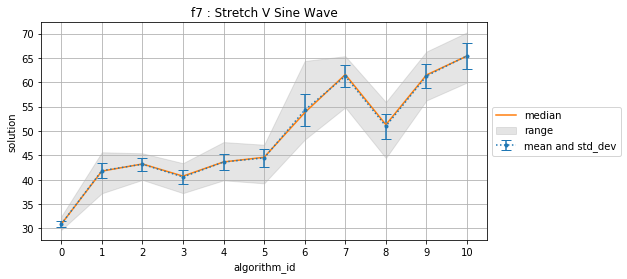

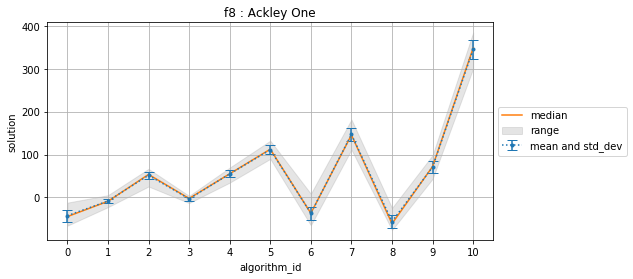

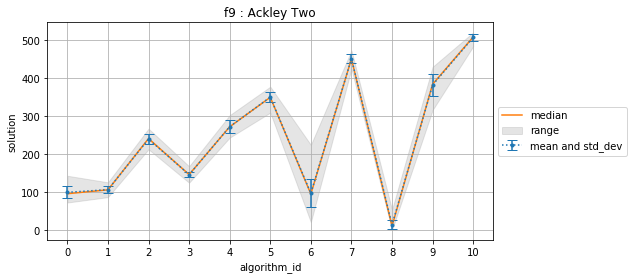

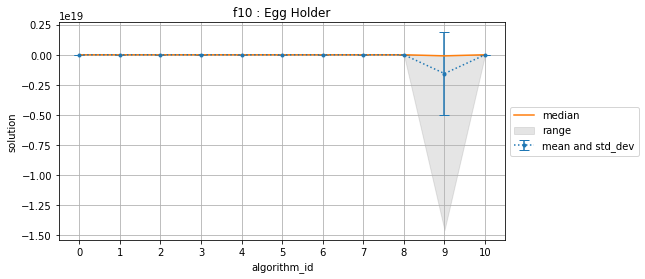

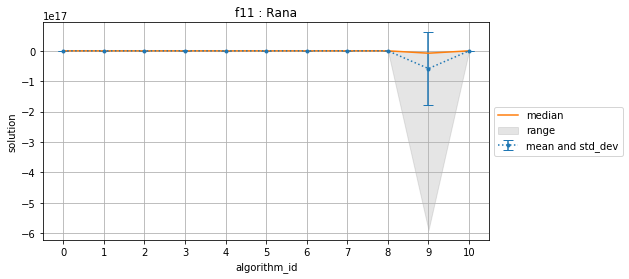

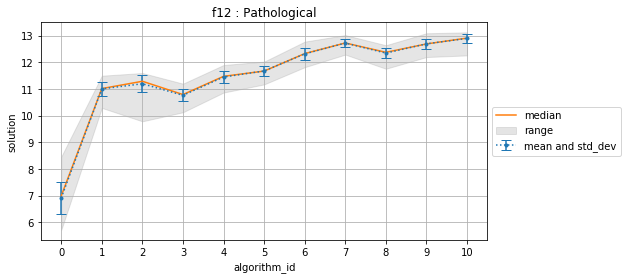

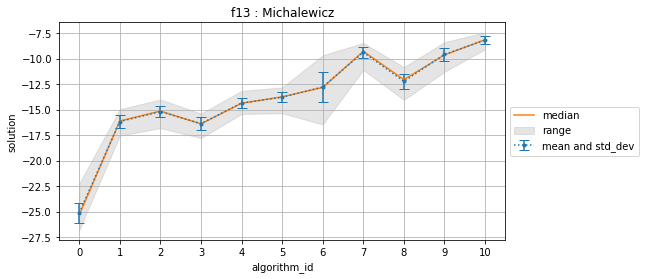

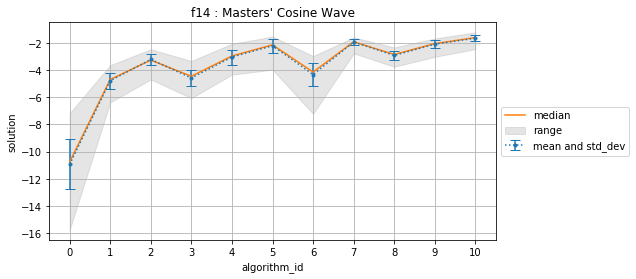

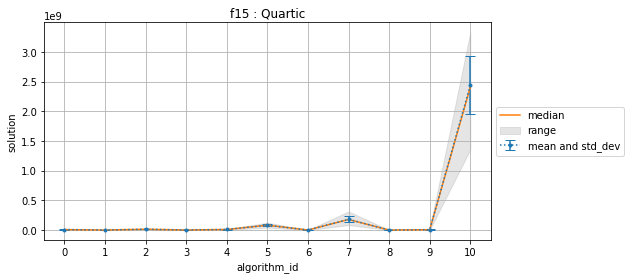

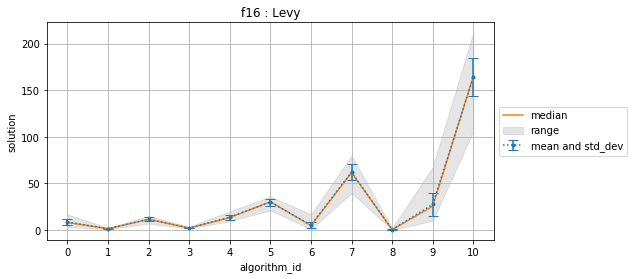

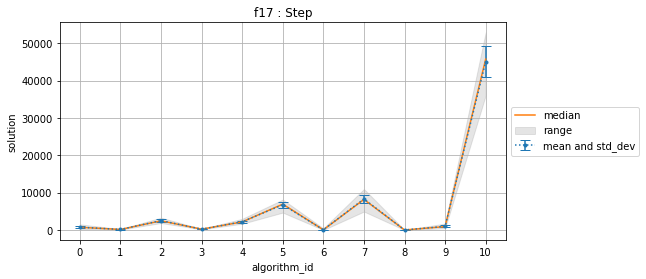

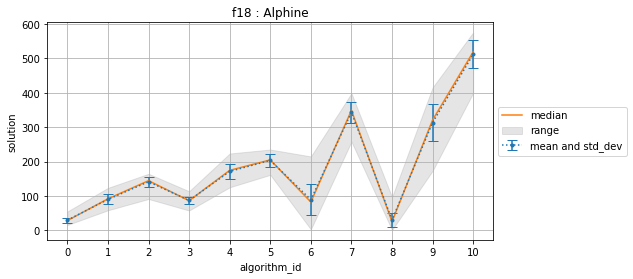

In [9]:
test.plot()

In [7]:
test.solution_df

,algorithm_id,function_id,n_runs,dimensions,range_low,range_high,mean,std_dev,range,median,time_ms,range_min,range_max
108,0,1,15,30,-512,512.0,1.360540e+03,5.536310e+02,2.118800e+03,1.272260e+03,950.215,2.522000e+02,2.371000e+03
37,0,2,15,30,-100,100.0,6.508180e+02,2.657690e+02,9.782720e+02,6.246480e+02,571.694,2.802030e+02,1.258480e+03
169,0,3,15,30,-100,100.0,2.443600e+07,1.941230e+07,7.979360e+07,1.727640e+07,661.866,1.762370e+06,8.155590e+07
16,0,4,15,30,-30,30.0,-3.301540e+04,1.187670e+04,5.524840e+04,-3.434660e+04,1036.890,-5.225300e+04,2.995410e+03
94,0,5,15,30,-500,500.0,4.917950e+00,2.666040e+00,1.097290e+01,4.032000e+00,1266.550,3.256840e+00,1.422970e+01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,10,14,15,30,-30,30.0,-1.586360e+00,1.453310e-01,5.001870e-01,-1.563860e+00,1988.420,-1.838530e+00,-1.338350e+00
57,10,15,15,30,-100,100.0,2.195180e+09,4.223120e+08,1.349220e+09,2.292680e+09,879.491,1.492150e+09,2.841380e+09
114,10,16,15,30,-10,10.0,1.681990e+02,1.914610e+01,7.833980e+01,1.667800e+02,2547.430,1.212260e+02,1.995660e+02
62,10,17,15,30,-100,100.0,4.203400e+04,3.476050e+03,1.216770e+04,4.142070e+04,910.505,3.618520e+04,4.835280e+04


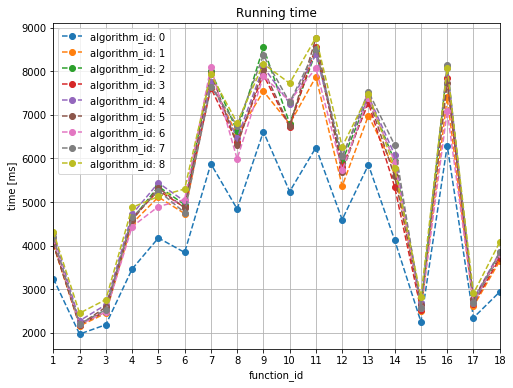

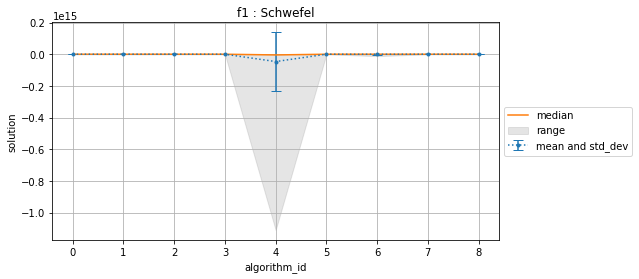

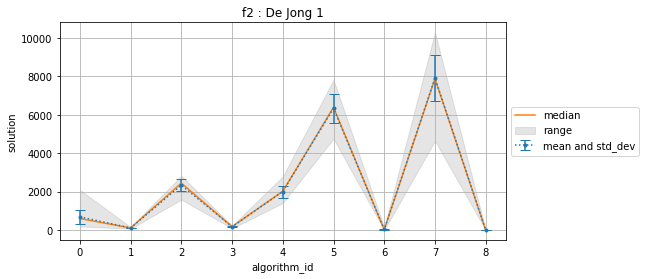

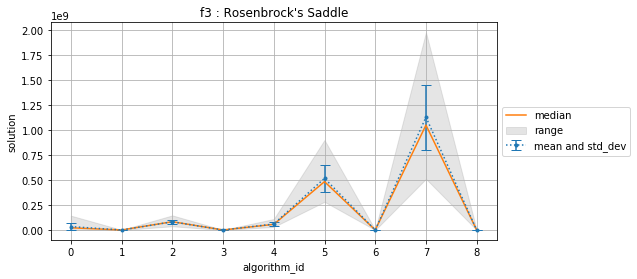

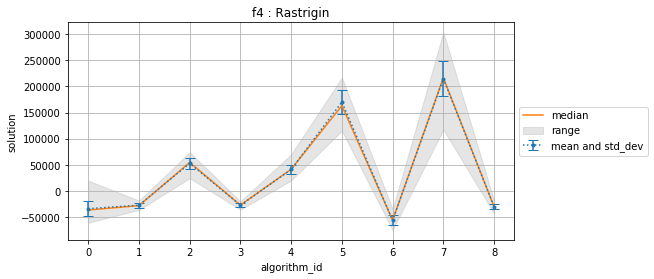

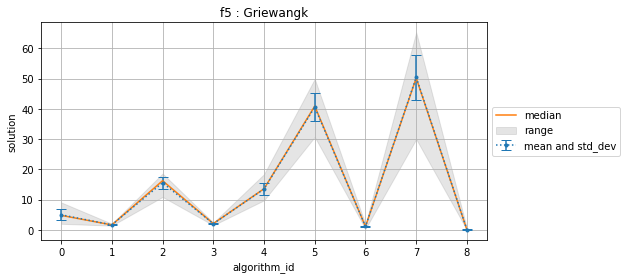

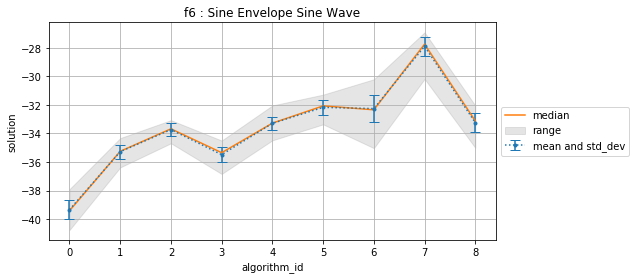

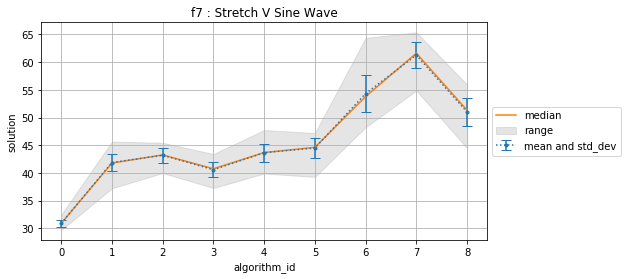

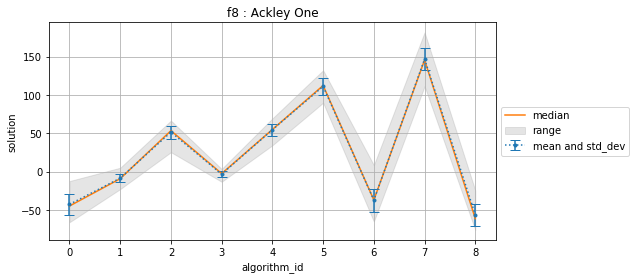

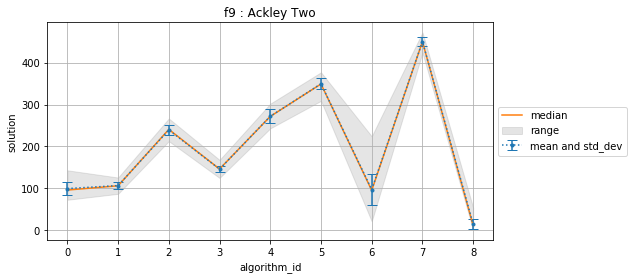

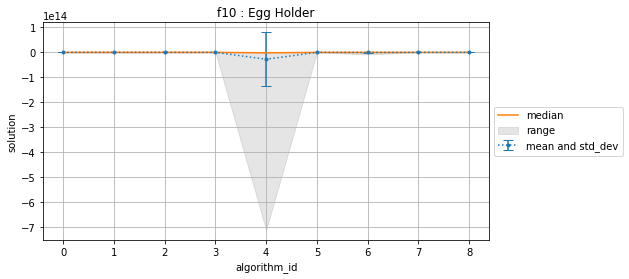

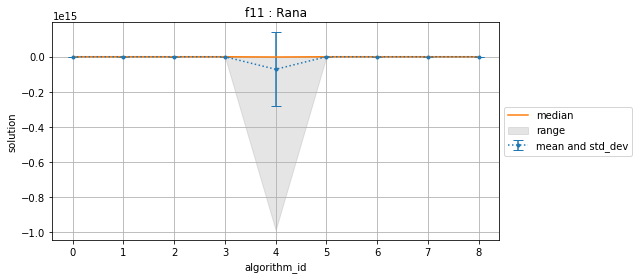

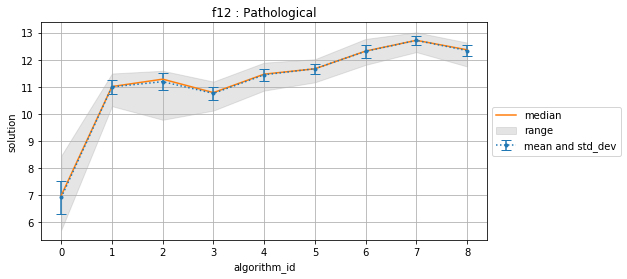

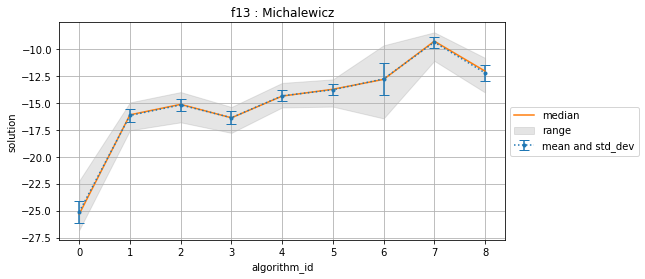

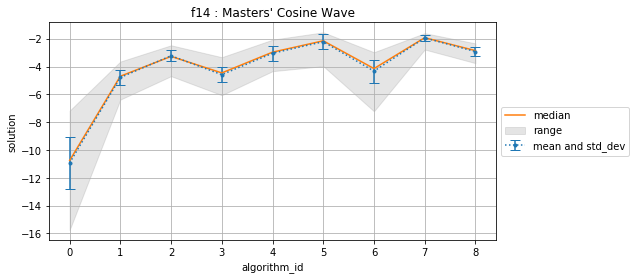

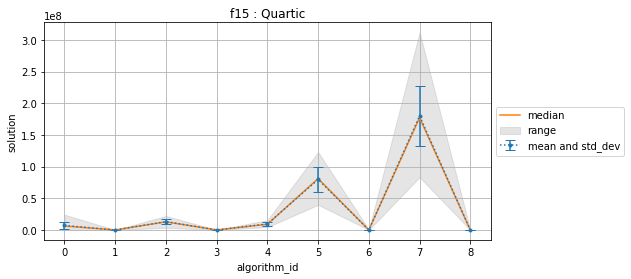

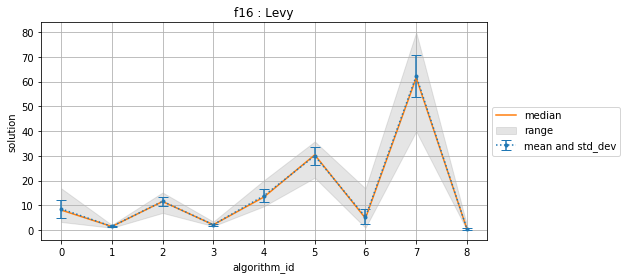

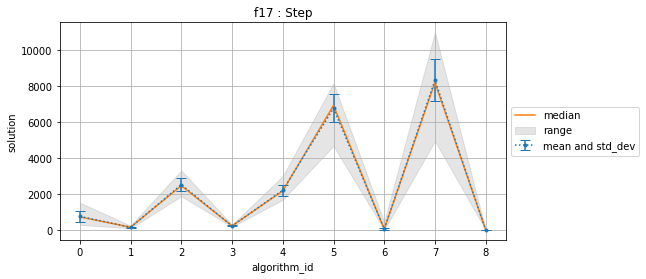

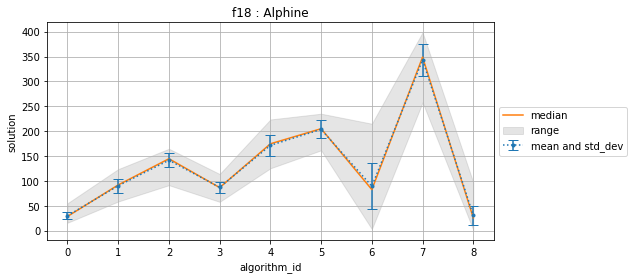

In [10]:
        df=pd.read_csv('solutions.csv',index_col=False)
        df.sort_values(by=['algorithm_id', 'function_id'], inplace = True)
        
        #delete 10
        df = df[df["algorithm_id"]!=10]
        df = df[df["algorithm_id"]!=9]
        #-----------plot running time
        fig, ax = plt.subplots(figsize=(8,6))
        for label, data in df.groupby('algorithm_id'):
            data.plot(kind='line',x='function_id',y='time_ms',ax=ax, style='o--', xticks=data['function_id'], label='algorithm_id: %d'%label)
        plt.ylabel('time [ms]')    
        plt.legend()
        plt.grid()
        plt.title('Running time')
        
   
        #---------plot statistics
        for id, data in df.groupby('function_id'):
            fig, ax = plt.subplots(figsize=(8,4))
            plt.errorbar(data['algorithm_id'],data['mean'],yerr=data['std_dev'],fmt='o:', markersize=3, capsize=5, label='mean and std_dev')
            plt.plot(data['algorithm_id'],data['median'],label='median')
            plt.fill_between(data['algorithm_id'], data['range_min'], data['range_max'], color='gray', alpha=0.2, label='range')
            plt.xticks(data['algorithm_id'])
            plt.title("f%d : %s"%(id, test.f_param_list_name[id-1]))
            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            plt.xlabel('algorithm_id')
            plt.ylabel('solution')
            plt.grid()
        

In [15]:
pd.options.display.max_rows
pd.set_option('display.max_rows', None)

In [19]:
pd.options.display.float_format = '{:.3f}'.format

In [20]:
df

,algorithm_id,function_id,n_runs,dimensions,range_low,range_high,mean,std_dev,range,median,time_ms,range_min,range_max
108,0,1,50,30,-512,512.000,1070.940,498.942,2516.150,1003.300,3245.250,-14.892,2501.250
37,0,2,50,30,-100,100.000,683.105,356.408,1899.220,598.215,1973.190,188.045,2087.270
169,0,3,50,30,-100,100.000,34029100.000,32227700.000,141698000.000,22344700.000,2187.660,2237380.000,143936000.000
16,0,4,50,30,-30,30.000,-33691.400,14859.200,80401.600,-36195.800,3464.110,-60519.900,19881.700
94,0,5,50,30,-500,500.000,5.007,1.859,7.069,4.809,4176.520,2.027,9.096
105,0,6,50,30,-30,30.000,-39.340,0.672,2.861,-39.416,3844.860,-40.766,-37.905
163,0,7,50,30,-30,30.000,30.886,0.607,2.790,30.878,5876.150,29.677,32.467
85,0,8,50,30,-32,32.000,-42.562,13.837,53.733,-44.749,4840.570,-65.915,-12.183
173,0,9,50,30,-32,32.000,99.231,15.871,70.448,95.651,6612.060,72.423,142.871
45,0,10,50,30,-500,500.000,-17387.000,1251.080,4835.630,-17606.100,5240.440,-19653.600,-14817.900


In [21]:
df.sort_values(by=['function_id','algorithm_id' ], inplace = True)

In [22]:
df

,algorithm_id,function_id,n_runs,dimensions,range_low,range_high,mean,std_dev,range,median,time_ms,range_min,range_max
108,0,1,50,30,-512,512.000,1070.940,498.942,2516.150,1003.300,3245.250,-14.892,2501.250
190,1,1,50,30,-512,512.000,-1758210000.000,7785360000.000,52808300000.000,-7691650.000,4022.610,-52808300000.000,-18082.800
155,2,1,50,30,-512,512.000,-12606.800,1635.350,7511.410,-12861.000,4042.670,-16274.300,-8762.900
59,3,1,50,30,-512,512.000,1016.510,1123.270,5065.850,1120.850,4045.420,-2393.380,2672.460
31,4,1,50,30,-512,512.000,-46376700000000.000,184512000000000.000,1109790000000000.000,-4521100000000.000,4284.640,-1109790000000000.000,-3103340000.000
150,5,1,50,30,-512,512.000,-76821.600,12218.000,81142.100,-77004.900,4062.460,-136447.000,-55304.700
112,6,1,50,30,-512,512.000,-303910000000.000,1720140000000.000,12255100000000.000,-44445.400,4153.790,-12255100000000.000,-4364.100
60,7,1,50,30,-512,512.000,-1616590.000,1968750.000,11222500.000,-1033940.000,4191.180,-11425400.000,-202826.000
124,8,1,50,30,-512,512.000,-5437.480,5911.430,28243.600,-3835.810,4316.430,-24514.800,3728.780
37,0,2,50,30,-100,100.000,683.105,356.408,1899.220,598.215,1973.190,188.045,2087.270
